# Create Visualizations from U.S. Census Data

In [1]:
import pandas as pd
import json
import requests
import os
from pathlib import Path
import re
import seaborn as sns

## Define a method to read in data

Method grabs all of the column names and then maps them

In [2]:
def read_data(data_path: str):
    # read in all of the files
    df_list = []
    for i in os.listdir(data_path):
        if i.endswith('Column-Metadata.csv'):
            df_list.append(pd.read_csv(data_path + '/' + i))
            
    df_cols = pd.concat(df_list)
    print(df_cols.shape)

    # create a dicitonary to map the column names
    col_map = dict(zip(list(df_cols['Column Name']),
                            list(df_cols['Label'])
                            ))
    
    # read in all of the data files and map all of the column names
    df_data_list = []
    for i in os.listdir(data_path):
        if i.endswith('Data.csv'):
            temp_df = pd.read_csv(data_path + '/' + i)
            temp_cols = [col_map[i] if i in col_map else i for i in temp_df.columns]
            temp_df.columns = temp_cols 
            # grab the year of the file
            grab_year = re.search('ACSDT5Y([0-9]{4})', i)
            grab_year = grab_year.group(1)
            temp_df['Year'] = grab_year
            df_data_list.append(temp_df)
            
    # combine all of the CSVs of the different years
    df = pd.concat(df_data_list)
    return df

## Rent as Percentage of Income

In [3]:
data_path = '../../data/csv/rent-productDownload_2023-11-06T145155'
rent_perc_df = read_data(data_path)
rent_perc_df.head()

(72, 2)


,Geography,Geographic Area Name,Estimate!!Median gross rent as a percentage of household income,Annotation of Estimate!!Median gross rent as a percentage of household income,Margin of Error!!Median gross rent as a percentage of household income,Annotation of Margin of Error!!Median gross rent as a percentage of household income,Unnamed: 6,Year
0,Geography,Geographic Area Name,Estimate!!Median gross rent as a percentage of...,Annotation of Estimate!!Median gross rent as a...,Margin of Error!!Median gross rent as a percen...,Annotation of Margin of Error!!Median gross re...,NaN,2014
1,1400000US11001000100,"Census Tract 1, District of Columbia, District...",20.1,NaN,2.9,NaN,NaN,2014
2,1400000US11001000201,"Census Tract 2.01, District of Columbia, Distr...",-,-,**,**,NaN,2014
3,1400000US11001000202,"Census Tract 2.02, District of Columbia, Distr...",42.5,NaN,27.3,NaN,NaN,2014
4,1400000US11001000300,"Census Tract 3, District of Columbia, District...",26.9,NaN,3.4,NaN,NaN,2014


# Rent Amount in Dollars

In [4]:
data_path = '../../data/csv/rent-price-productDownload_2023-11-06T152545'
rent_dollars_df = read_data(data_path)
rent_dollars_df.head()


(72, 2)


,Geography,Geographic Area Name,Margin of Error!!Median gross rent,Annotation of Margin of Error!!Median gross rent,Estimate!!Median gross rent,Annotation of Estimate!!Median gross rent,Unnamed: 6,Year
0,Geography,Geographic Area Name,Margin of Error!!Median gross rent,Annotation of Margin of Error!!Median gross rent,Estimate!!Median gross rent,Annotation of Estimate!!Median gross rent,NaN,2010
1,1400000US11001000100,"Census Tract 1, District of Columbia, District...",127,NaN,1485,NaN,NaN,2010
2,1400000US11001000201,"Census Tract 2.01, District of Columbia, Distr...",**,**,-,-,NaN,2010
3,1400000US11001000202,"Census Tract 2.02, District of Columbia, Distr...",***,***,"2,000+","2,000+",NaN,2010
4,1400000US11001000300,"Census Tract 3, District of Columbia, District...",242,NaN,1767,NaN,NaN,2010


# Clean Data

In [5]:
def clean_cols(input_df, col_name):
    # create a column that just has the county name
    input_df.loc[:, 'County'] = input_df['Geographic Area Name'].apply(lambda x: re.search('([A-Za-z ]+) County', x).group(0).strip() if re.search('(.*) County', x) else 'District of Columbia')

    # turn year into datettime
    input_df.loc[:, 'Year'] = pd.to_datetime(input_df['Year'], format = '%Y')

    # drop unncessary columns
    cols_to_keep = [i for i in input_df.columns if not re.search('Margin|Annotation|Unnamed', i)]
    input_df = input_df[cols_to_keep].copy()
    
    # drop any rows that are not numeric
    input_df = input_df[pd.to_numeric(input_df[col_name], errors='coerce').notnull()]
    input_df.loc[:, col_name] = pd.to_numeric(input_df.loc[:, col_name])
    
    return input_df

In [6]:
rent_perc_df = clean_cols(rent_perc_df, 'Estimate!!Median gross rent as a percentage of household income')
rent_perc_df.head()

,Geography,Geographic Area Name,Estimate!!Median gross rent as a percentage of household income,Year,County
1,1400000US11001000100,"Census Tract 1, District of Columbia, District...",20.1,2014-01-01,District of Columbia
3,1400000US11001000202,"Census Tract 2.02, District of Columbia, Distr...",42.5,2014-01-01,District of Columbia
4,1400000US11001000300,"Census Tract 3, District of Columbia, District...",26.9,2014-01-01,District of Columbia
5,1400000US11001000400,"Census Tract 4, District of Columbia, District...",35.7,2014-01-01,District of Columbia
6,1400000US11001000501,"Census Tract 5.01, District of Columbia, Distr...",27.5,2014-01-01,District of Columbia


In [7]:
rent_dollars_df.columns

Index(['Geography', 'Geographic Area Name',
       'Margin of Error!!Median gross rent',
       'Annotation of Margin of Error!!Median gross rent',
       'Estimate!!Median gross rent',
       'Annotation of Estimate!!Median gross rent', 'Unnamed: 6', 'Year'],
      dtype='object')

In [8]:
rent_dollars_df = clean_cols(rent_dollars_df, 'Estimate!!Median gross rent')
rent_dollars_df.head()

,Geography,Geographic Area Name,Estimate!!Median gross rent,Year,County
1,1400000US11001000100,"Census Tract 1, District of Columbia, District...",1485,2010-01-01,District of Columbia
4,1400000US11001000300,"Census Tract 3, District of Columbia, District...",1767,2010-01-01,District of Columbia
5,1400000US11001000400,"Census Tract 4, District of Columbia, District...",1528,2010-01-01,District of Columbia
6,1400000US11001000501,"Census Tract 5.01, District of Columbia, Distr...",1648,2010-01-01,District of Columbia
7,1400000US11001000502,"Census Tract 5.02, District of Columbia, Distr...",1319,2010-01-01,District of Columbia


In [9]:
if 'Estimate!!Median gross rent as a percentage of household income' in rent_perc_df.columns:
    rent_perc_df = rent_perc_df.rename({'Estimate!!Median gross rent as a percentage of household income' : 'Rent as Percent of Income'}, axis = 'columns')
    
if 'Estimate!!Median gross rent' in rent_dollars_df.columns:
    rent_dollars_df = rent_dollars_df.rename({'Estimate!!Median gross rent' : 'Rent in USD'}, axis = 'columns')

In [10]:
rent_dollars_df.columns

Index(['Geography', 'Geographic Area Name', 'Rent in USD', 'Year', 'County'], dtype='object')

# Write Cleaned Data to CSV

In [11]:
rent_perc_df.to_csv('../../data/csv/rent_as_percent_of_income.csv', index=True)
rent_dollars_df.to_csv('../../data/csv/rent_in_dollars.csv', index=True)


# Data Visualizations

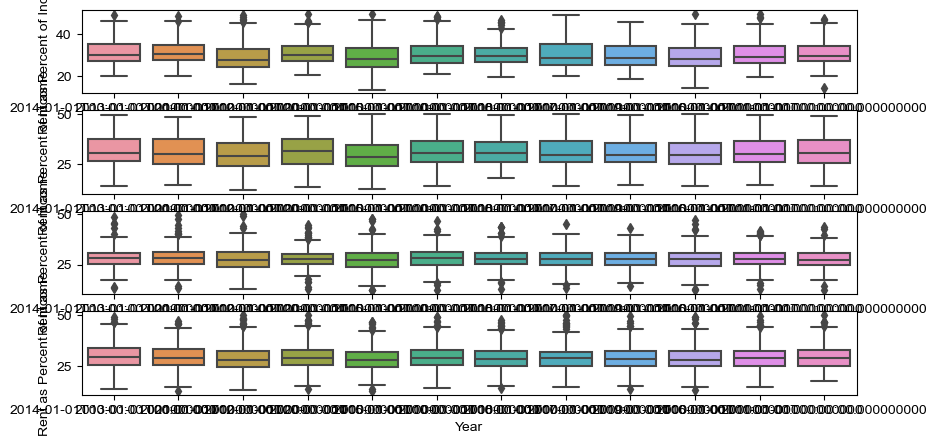

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 1, figsize=(10,5))
sns.set(rc={'figure.figsize':(11.7,8.27)})

year_filter = (rent_perc_df.Year.dt.year == 2021)
count = 0
for each_county in list(rent_perc_df.County.unique()):
    # plt.figure(i)
    county_filter = (rent_perc_df.County == each_county)
    sns.boxplot(x = 'Year', y = 'Rent as Percent of Income', data = rent_perc_df[county_filter], ax=ax[count])
    count += 1

Text(0.5, 1.0, 'Rent as Percentage of Income for 2021')

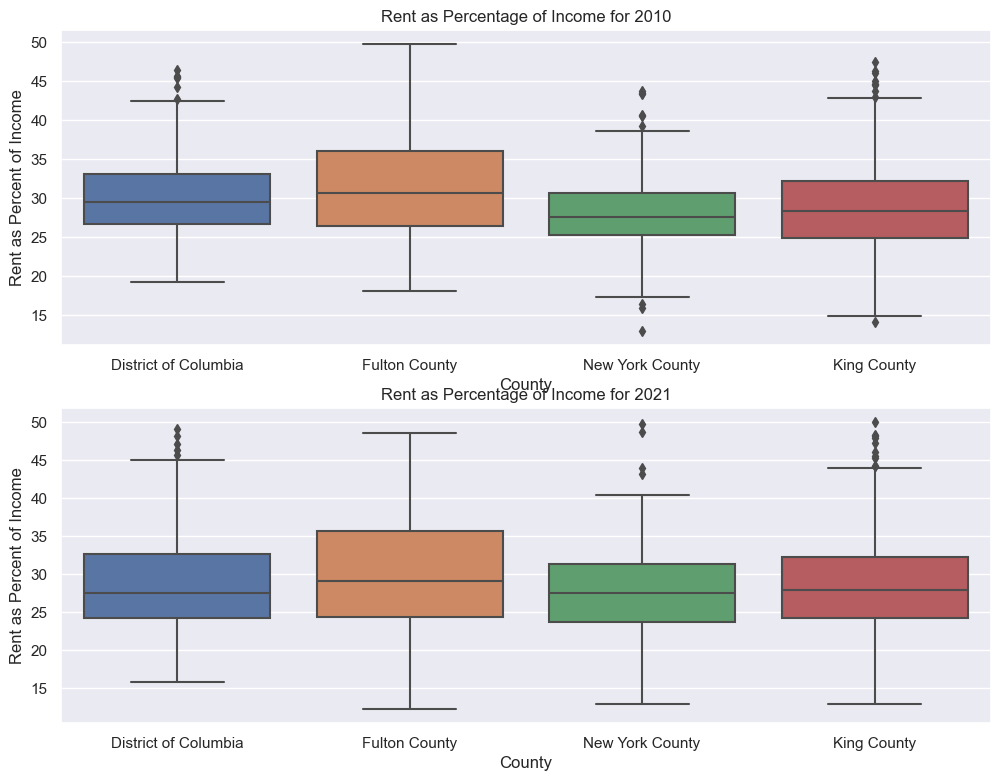

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(12,9))
sns.set(rc={'figure.figsize':(11.7,8.27)})

year_filter = (rent_perc_df.Year.dt.year == 2010)

sns.boxplot(x = 'County',
            y = 'Rent as Percent of Income',
            data = rent_perc_df[year_filter],
            ax = ax[0])
ax[0].set_title("Rent as Percentage of Income for 2010")

year_filter = (rent_perc_df.Year.dt.year == 2021)
sns.boxplot(x = 'County',
            y = 'Rent as Percent of Income',
            data = rent_perc_df[year_filter],
            ax = ax[1])
ax[1].set_title("Rent as Percentage of Income for 2021")

# year_filters = (rent_perc_df.year.dt.year == 2021) | (rent_perc_df.year.dt.year == 2010)
# lineplots = sns.FacetGrid(rent_perc_df,
#                           col="County",
#                           margin_titles = True,
#                           hue="County",
#                           col_wrap=2,
#                           aspect=1.1,
#                           height=5
#                  )

# lineplots.map(sns.lineplot,
#               "year",
#               "Rent in USD",
#               linewidth=2
#      )

# lineplots.set_titles(col_template = "{col_name}")  # use this argument literally
        
# lineplots.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
# lineplots.fig.suptitle('Most Gentrified U.S. Cities Rent Prices from 2010 - 2021', fontdict={'size':25})



Text(0.5, 0.98, 'Most Gentrified U.S. Cities Rent Prices from 2010 - 2021')

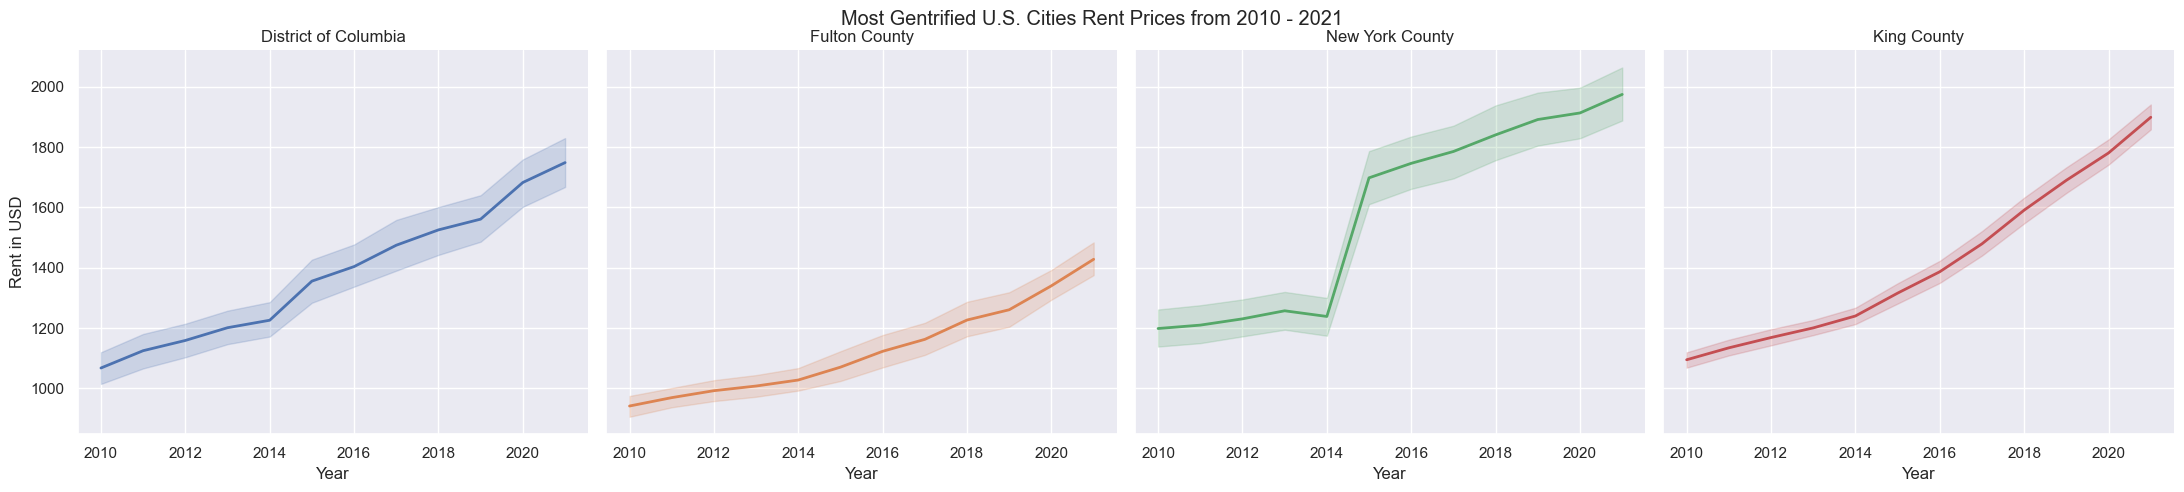

In [14]:
city_mappings = {'District of Columbia': 'washingtondc',
                    'Fulton County': 'Atlanta',
                    'New York County': 'nyc',
                    'King County': 'Seattle'}

rent_dollars_df.loc[:, 'city'] = rent_dollars_df.loc[:, 'County'].map()

lineplots = sns.FacetGrid(rent_dollars_df,
                          col="County",
                          margin_titles = True,
                          hue="County",
                          col_wrap=4,
                          aspect=1.1,
                          col_order=['washingtondc', 'Atlanta', 'nyc', 'Seattle'],
                          height=5
                 )

lineplots.map(sns.lineplot,
              "Year",
              "Rent in USD",
              linewidth=2
     )

lineplots.set_titles(col_template = "{col_name}")  # use this argument literally
        
lineplots.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
lineplots.fig.suptitle('Most Gentrified U.S. Cities Rent Prices from 2010 - 2021', fontdict={'size':25})


/var/folders/g9/n5sfsl5n0z98mvb4hh40ftzr0000gn/T/ipykernel_64020/1787382017.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  r.set_yticklabels(ylabels)


[Text(0, 800.0, '$800'),
 Text(0, 1000.0, '$1,000'),
 Text(0, 1200.0, '$1,200'),
 Text(0, 1400.0, '$1,400'),
 Text(0, 1600.0, '$1,600'),
 Text(0, 1800.0, '$1,800'),
 Text(0, 2000.0, '$2,000'),
 Text(0, 2200.0, '$2,200')]

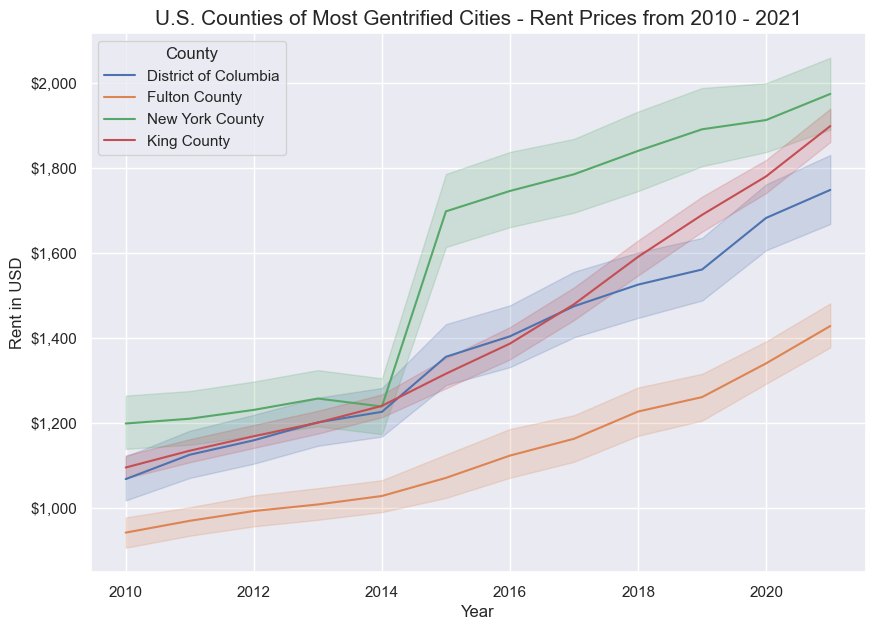

In [15]:
fig, ax = plt.subplots(figsize=(10, 7))
r = sns.lineplot(rent_dollars_df,
                x = 'Year',
                y = 'Rent in USD',
                hue = 'County')

ax.set_title('U.S. Counties of Most Gentrified Cities - Rent Prices from 2010 - 2021', fontdict={'size':15})

ylabels = ['${:,.0f}'.format(y) for y in r.get_yticks()]
r.set_yticklabels(ylabels)

In [25]:
# rent_dollars_df[~rent_dollars_df['Geographic Area Name'].str.contains('District of Columbia')]['Geographic Area Name'].unique()

rent_dollars_df[rent_dollars_df['Geographic Area Name'].str.contains('Fulton County')]['Geographic Area Name'].head()

rent_dollars_df[rent_dollars_df['Geographic Area Name'].str.contains('Fulton County')]['Geography'].unique()

array(['1400000US13121000100', '1400000US13121000200',
       '1400000US13121000400', '1400000US13121000500',
       '1400000US13121000600', '1400000US13121000700',
       '1400000US13121001001', '1400000US13121001002',
       '1400000US13121001100', '1400000US13121001201',
       '1400000US13121001202', '1400000US13121001300',
       '1400000US13121001400', '1400000US13121001500',
       '1400000US13121001600', '1400000US13121001700',
       '1400000US13121001800', '1400000US13121001900',
       '1400000US13121002100', '1400000US13121002300',
       '1400000US13121002400', '1400000US13121002500',
       '1400000US13121002600', '1400000US13121002800',
       '1400000US13121002900', '1400000US13121003000',
       '1400000US13121003100', '1400000US13121003200',
       '1400000US13121003500', '1400000US13121003600',
       '1400000US13121003700', '1400000US13121003800',
       '1400000US13121003900', '1400000US13121004000',
       '1400000US13121004100', '1400000US13121004200',
       '14

In [45]:
# rent_dollars_df.loc[:, 'year-place'] = rent_dollars_df['Geographic Area Name']+rent_dollars_df.loc[:, 'Year'].astype(str)
# rent_perc_df.loc[:, 'year-place'] = rent_perc_df['Geographic Area Name']+rent_perc_df.loc[:, 'Year'].astype(str)

rent_df = rent_dollars_df.merge(rent_perc_df, on=['Year', 'Geographic Area Name'], how = 'outer')
rent_df.loc[:, 'County'] = rent_df.loc[:, 'County_x'].fillna(rent_df.loc[:, 'County_y'])
rent_df.loc[:, 'month_county'] = rent_df.loc[:, 'County']+rent_df.loc[:, 'Year'].astype(str)
len(rent_df)

13065

In [33]:
rent_df.head()

rent_df[rent_df.Year_x.isna()]

,Geography_x,Geographic Area Name_x,Rent in USD,Year_x,County_x,year-county,Geography_y,Geographic Area Name_y,Rent as Percent of Income,Year_y,County_y


In [34]:
len(rent_dollars_df)

12433

In [49]:
rent_df.head()

rent_df_agg = rent_df.groupby(['Year', 'County'])[['Rent in USD', 'Rent as Percent of Income']].median().reset_index()

,Year,County,Rent in USD,Rent as Percent of Income
0,2010-01-01,District of Columbia,951.0,29.50
1,2010-01-01,Fulton County,937.0,30.70
2,2010-01-01,King County,1054.0,28.40
3,2010-01-01,New York County,1078.0,27.65
4,2011-01-01,District of Columbia,1040.0,29.35
5,2011-01-01,Fulton County,958.0,30.80
6,2011-01-01,King County,1095.5,28.60
7,2011-01-01,New York County,1059.5,27.40
8,2012-01-01,District of Columbia,1070.0,29.80
9,2012-01-01,Fulton County,966.0,31.50


In [ ]:
rent_df.loc[:,'month-county'] = rent_df.loc[:, 'Year_x', '']